In [1]:
import math,numpy as np,matplotlib.pyplot as plt
from operator import itemgetter
from pprint import pprint
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

from miniai.training import *

In [2]:
import logging,pickle,gzip,os,time,shutil,torch,matplotlib as mpl
from pathlib import Path

from torch import tensor,nn,optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset,load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

c:\Users\grzeg\Miniconda3\envs\fastai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'
     
logging.disable(logging.WARNING)

# Hugging Face Datasets

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.

load_dataset_builder is used to insect the data before loading it to your filesystem

In [4]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)

In [5]:
pprint(ds_builder.info.features)

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle boot'],
                     id=None)}


In [6]:
pprint(ds_builder.info.splits)

{'test': SplitInfo(name='test',
                   num_bytes=5235160,
                   num_examples=10000,
                   shard_lengths=None,
                   dataset_name='fashion_mnist'),
 'train': SplitInfo(name='train',
                    num_bytes=31304707,
                    num_examples=60000,
                    shard_lengths=None,
                    dataset_name='fashion_mnist')}


# Loading DataSet Dict from HF

In [7]:
dsd = load_dataset(name)
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [8]:
train, test = dsd["train"], dsd["test"]

In [9]:
train

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [10]:
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [11]:
x,y = ds_builder.info.features
x,y

('image', 'label')

In [12]:
img = train[0][x]
img

In [13]:
xb = train[:5][x]
yb = train[:5][y]

xb, yb

([<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
 [9, 0, 0, 3, 0])

we want to now know which IDs map to their corresponding labels 

In [14]:
featy = train.features[y]
pprint(featy)

ClassLabel(names=['T - shirt / top',
                  'Trouser',
                  'Pullover',
                  'Dress',
                  'Coat',
                  'Sandal',
                  'Shirt',
                  'Sneaker',
                  'Bag',
                  'Ankle boot'],
           id=None)


In [15]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [16]:
# Note that we can do all of our work in the collation function
# 1. go through each item in a batch
# 2. grab x from each item
# 3. convert it to a tensor
# 4. stack them together into one tensor

def collate_fn(b):
    return {x:torch.stack([torch.flatten(TF.to_tensor(o[x])) for o in b]),
            y:tensor([o[y] for o in b])}

In [17]:
bs = 16

dl = DataLoader(train, collate_fn=collate_fn, batch_size=bs)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 784]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

The second approach is to use with_transform method that HF datasets have and it allows us to transform a batch of data. Note that we need to return a new transformed batch

In [18]:
def transforms(b):
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]
    return b

DataLoader from pytorch can taka DataSet Dictionary 

In [19]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 784]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [20]:
def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

transformi = inplace(_transformi)

In [21]:
r = train.with_transform(transformi)[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

In [22]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [23]:
t = torch.tensor([[[1, 2],
                   [3, 4]],
                  [[5, 6],
                   [7, 8]]])

t.shape

torch.Size([2, 2, 2])

In [24]:
torch.flatten(t)

tensor([1, 2, 3, 4, 5, 6, 7, 8])

In [25]:
torch.flatten(t, start_dim=1)

tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])

In [26]:
train

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [27]:
tdsf = train.with_transform(transformi)
tdsf

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [28]:
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [29]:
dl = DataLoader(tdsf, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 784]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [30]:
b

{'image': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'label': tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])}

we note that our dataloader returns now a dictionary for each batch and before we had a tuple. In order to have tuples we can use itemgetter and replace default collate function in DataSet

## itemgetter

itemgetter allows us to get values with a specific key or attribute name from python objects

In [31]:
d = dict(a=1,b=2,c=3)
ig = itemgetter('a','c')
ig(d)

(1, 3)

In [32]:
class D:
    def __getitem__(self, k): return 1 if k=='a' else 2 if k=='b' else 3

d = D()
ig(d)

(1, 3)

In [132]:
d['a']

1

In [129]:
batch = dict(a=[1],b=[2]), dict(a=[3],b=[4]), dict(a=[5],b=[6])
batch

({'a': [1], 'b': [2]}, {'a': [3], 'b': [4]}, {'a': [5], 'b': [6]})

In [128]:
ig = itemgetter('a','b')
ig(batch[0])

([1], [2])

default_collate function from pytorch will grab all all items from an iterator with the same key name and stack them together. We need to ensure that all elements in the iterator have the same keys

In [34]:
default_collate(batch)

{'a': [tensor([1, 3, 5])], 'b': [tensor([2, 4, 6])]}

In [35]:
list(tdsf.features)

['image', 'label']

In [36]:
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [37]:
b

{'image': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'label': tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])}

In [38]:
get = itemgetter(*tdsf.features)
get(b)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [39]:
dl = DataLoader(tdsf, batch_size=4)
b = next(iter(dl))
b

{'image': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'label': tensor([9, 0, 0, 3])}

In [40]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
b = next(iter(dlf))
b

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 0, 0, 3]))

huggingface use to do things with dictionaries and other libraries usually work with tuples 

# Plotting

In [53]:
dlf = DataLoader(tdsf, batch_size=16, collate_fn=collate_dict(tdsf))
b = next(iter(dlf))
xb, yb = b

In [54]:
img = xb[0]
img.shape

torch.Size([784])

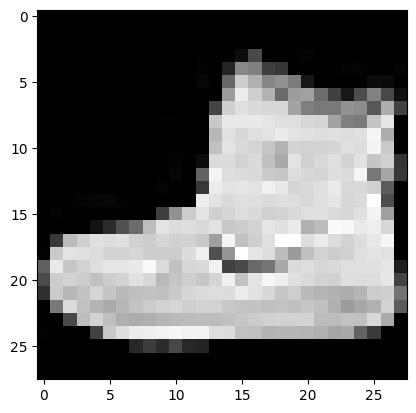

In [55]:
img = img.view(28,28)
plt.imshow(img)

In [56]:
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off') # remove ticks from axis
    return ax

In [57]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on `ax`.



<Axes: >

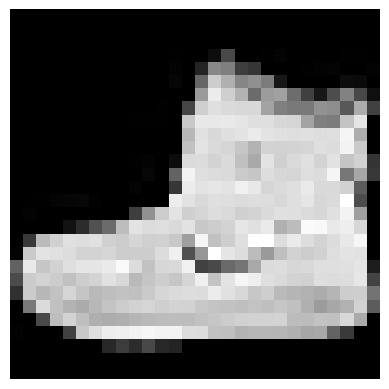

In [58]:
show_image(img)

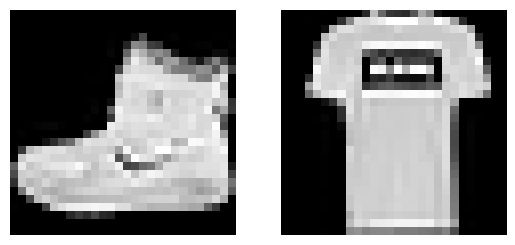

In [59]:
fig,axs = plt.subplots(1,2)
show_image(img, axs[0])
show_image(xb[1].view(28,28), axs[1]);

In [60]:
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

In [61]:
from nbdev.showdoc import show_doc

In [62]:
show_doc(subplots)

---

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None,
>                sharex:"bool|Literal['none','all','row','col']"=False,
>                sharey:"bool|Literal['none','all','row','col']"=False,
>                squeeze:bool=True, width_ratios:Sequence[float]|None=None,
>                height_ratios:Sequence[float]|None=None,
>                subplot_kw:dict[str,Any]|None=None,
>                gridspec_kw:dict[str,Any]|None=None, **kwargs)

*A figure and set of subplots to display images of `imsize` inches*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool \| Literal['none', 'all', 'row', 'col'] | False |  |
| sharey | bool \| Literal['none', 'all', 'row', 'col'] | False |  |
| squeeze | bool | True |  |
| width_ratios | Sequence[float] \| None | None |  |
| height_ratios | Sequence[float] \| None | None |  |
| subplot_kw | dict[str, Any] \| None | None |  |
| gridspec_kw | dict[str, Any] \| None | None |  |
| kwargs |  |  |  |

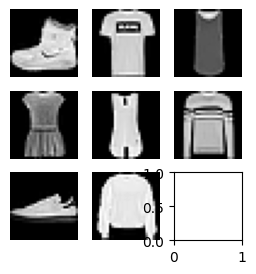

In [96]:
fig,axs = subplots(3,3, imsize=1)
imgs = xb[:8]
for ax,img in zip(axs.flat,imgs): show_image(img.view(28,28), ax)

In [75]:
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.ceil(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

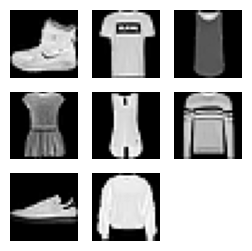

In [79]:
fig,axs = get_grid(8, nrows=3, imsize=1)
for ax,img in zip(axs.flat,imgs): show_image(img.view(28,28), ax)

In [80]:
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [86]:
lbls = yb[:8]
lbls

tensor([9, 0, 0, 3, 0, 2, 7, 2])

In [87]:
featy.int2str(lbls)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top',
 'Pullover',
 'Sneaker',
 'Pullover']

In [88]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

In [110]:
imgs = imgs.view(8, 28, 28)
imgs.shape


torch.Size([8, 28, 28])

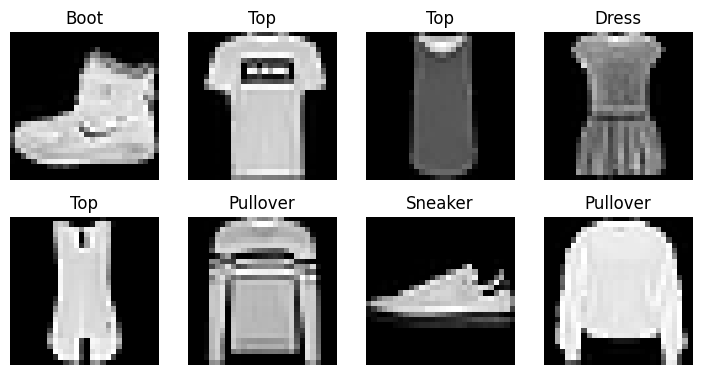

In [113]:
show_images(imgs, imsize=2.2, titles=titles)